<h1>Module Description</h1>

The model I chose is the CNN ([Convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network)). Due to the ability to fold bunch of features to one, so that it can recognize complex features in each image. Also the CNN is intendend to solve image's problems. However I have a huge drawback in my implementation, I amassed only 3000 images (it is the really samll amount for the problem like I defined). Therefore the accuracy of the model will be sufficiently low, I will try to enhance the model, bot the accuracy augmentation will be scanty.

I've checked the approches used by others, and decided that the simple CNN is not enough for such small dataset. Hence, I will use the already pre-trained model [VGG16/VGG19](https://keras.io/api/applications/vgg/). The VGG is pre-trained on ImageNet CNN, it just uploads the wieghts. 

<h2>Import Libraries</h2>

In [1]:
%matplotlib inline
from keras import applications
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.metrics import AUC

<h2>Define some global variables</h2>

* **img_size** - The image size corresponds to extracted image's size
* **[_lambda](https://developers.google.com/machine-learning/crash-course/regularization-for-simplicity/lambda)** - regularization rate: $minimize(Loss(Data\mid Model) + \lambda \times complexity(Model))$

In [2]:
img_size = 256
_lambda = 0.01

<h2>Extract training data</h2>

We derive the data we got from `data_prepairing.ipynb`

In [3]:
data = np.load('processed_val_images.npy')
labels = np.load('processed_val_labels.npy')

print(data.shape)
print(labels.shape)

(2815, 256, 256, 3)
(2815,)


<h2>Training data split</h2>

Split the training data to the training/test datasets , according to the [80/20 rule](https://en.wikipedia.org/wiki/Pareto_principle).

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size = 0.8, random_state = 20)

nb_classes = 2
y_train = np.array(y_train)
y_test = np.array(y_test)
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

print("Training label shape", Y_train.shape)
print("Testing label shape", Y_test.shape)

Training matrix shape (2252, 256, 256, 3)
Testing matrix shape (563, 256, 256, 3)
Training label shape (2252, 2)
Testing label shape (563, 2)


<h1>Model creating</h1>
As I said before, the VGG19 (the pre-trained network) is the base of my CNN. I have no ample of images, therefore it's reasonable to use a network wich has been pre-trained on other images. 

In [5]:
model = applications.VGG19(weights="imagenet", include_top=False, input_shape = (img_size, img_size, 3))

In [6]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [7]:
top_model = Sequential()

top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(2, activation='softmax'))

In [8]:
new_model = Sequential() #new model
for layer in model.layers: 
    new_model.add(layer)
    
new_model.add(top_model) # now this works

In [9]:
for layer in model.layers[:21]:
    layer.trainable = False

In [13]:
adam = optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.7, nesterov=True)
new_model.compile(loss='categorical_crossentropy',
              optimizer= adam,
              metrics='accuracy')

In [14]:
m1 = new_model.fit(X_train, Y_train, batch_size=16, epochs=10, verbose=2)

Epoch 1/10
141/141 - 432s - loss: 0.7295 - accuracy: 0.5111
Epoch 2/10
141/141 - 431s - loss: 0.7005 - accuracy: 0.5231
Epoch 3/10
141/141 - 431s - loss: 0.6889 - accuracy: 0.5493
Epoch 4/10
141/141 - 443s - loss: 0.6877 - accuracy: 0.5515
Epoch 5/10
141/141 - 432s - loss: 0.6852 - accuracy: 0.5497
Epoch 6/10
141/141 - 430s - loss: 0.6856 - accuracy: 0.5480
Epoch 7/10
141/141 - 430s - loss: 0.6775 - accuracy: 0.5688
Epoch 8/10
141/141 - 431s - loss: 0.6799 - accuracy: 0.5724
Epoch 9/10
141/141 - 430s - loss: 0.6754 - accuracy: 0.5768
Epoch 10/10
141/141 - 430s - loss: 0.6773 - accuracy: 0.5710


The model isn't overfitted

In [15]:
score = new_model.evaluate(X_test, Y_test, verbose=0)
print("Loss: " + str(score[0]))
print("Accuracy: " + str(score[1]))

Loss: 0.6756886839866638
Accuracy: 0.577264666557312


In [21]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1, figsize=(16,9))
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    #plt.xlim(xmin=0)
    plt.ylim(ymin=0)
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2, figsize=(16,9))
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    #plt.ylim(0, 1)    
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

As you may see, after the second epoch the loss are virtually the same

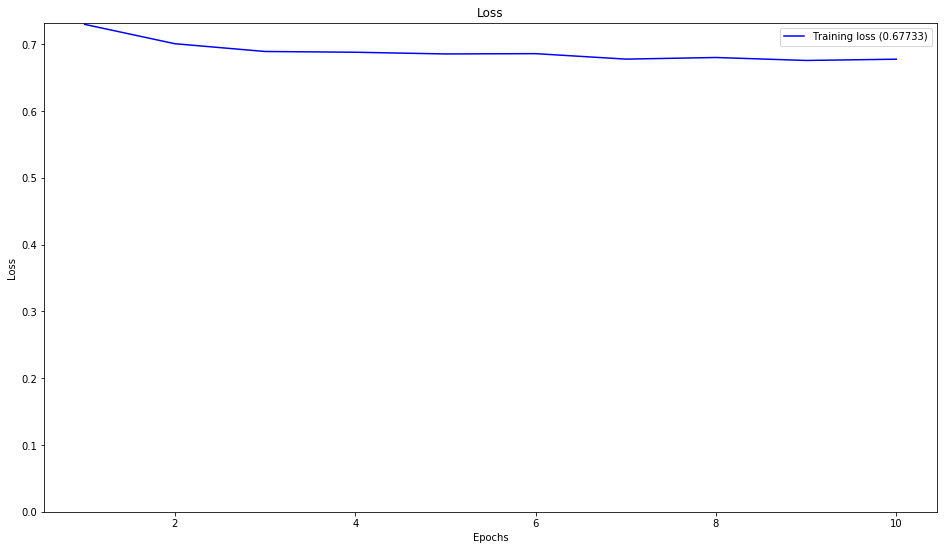

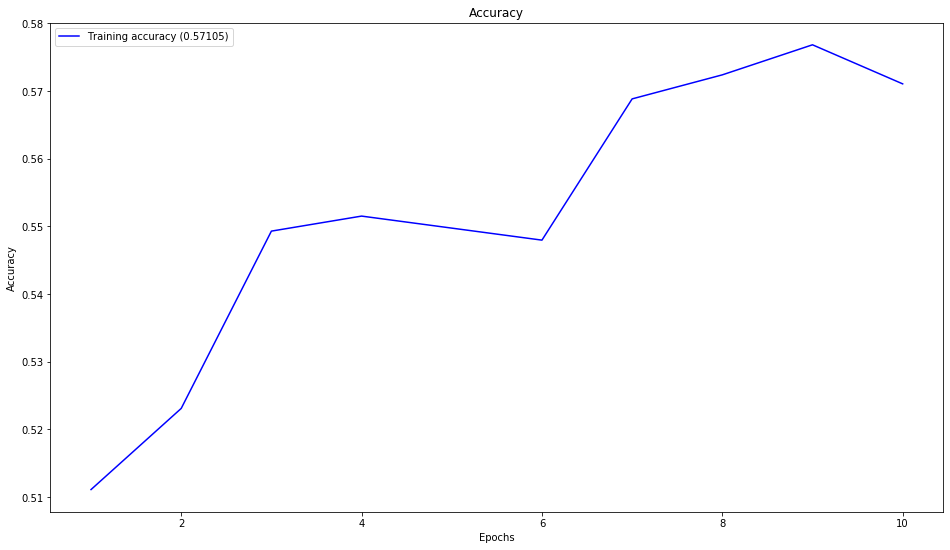

In [22]:
plot_history(m1)

In [27]:
new_model.save('milka_70_model_V3.h5')